# Imports

In [1]:
using Statistics, Ipopt, JuMP, Plots, LinearAlgebra

# Question 1

In [2]:
Rets = [0.08, 0.07, 0.1, 0.12, 0.09]
Vols = [0.25, 0.3, 0.28, 0.4, 0.35]
CorrMatrix = fill(0.3, (5,5))
CorrMatrix[diagind(CorrMatrix)] .= 1 # diagind function here changes diagonals to 1 to give us the created Correlation Matrix
DiagVol = diagm(Vols)
Q = DiagVol * CorrMatrix * DiagVol

5×5 Matrix{Float64}:
 0.0625   0.0225  0.021   0.03    0.02625
 0.0225   0.09    0.0252  0.036   0.0315
 0.021    0.0252  0.0784  0.0336  0.0294
 0.03     0.036   0.0336  0.16    0.042
 0.02625  0.0315  0.0294  0.042   0.1225

In [3]:
function generate_weights(n)
    weights = rand(n)
    return weights/sum(weights)
end

function portfolio_performance(weights, returns, cov_matrix)
    port_return = dot(weights, returns)
    port_volatility = sqrt(weights' * cov_matrix * weights)[1]
    return port_return, port_volatility
end
function find_tangency_portfolio(returns, cov_matrix, risk_free_rate)
    n = length(returns)
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, weights[1:n] >= 0)
    @constraint(model, sum(weights) == 1)

    # Calculate the portfolio return and variance
    portfolio_return = sum(weights[i] * returns[i] for i in 1:n)
    portfolio_variance = sum(weights[i] * weights[j] * cov_matrix[i, j] for i in 1:n, j in 1:n)
    portfolio_std_dev = sqrt(portfolio_variance)

    # Maximize the Sharpe ratio
    @NLobjective(model, Max, (portfolio_return - risk_free_rate) / portfolio_std_dev)

    optimize!(model)
    
    tangency_weights = value.(weights)
    tangency_return = value(portfolio_return)
    tangency_std_dev = value(portfolio_std_dev)
    return tangency_weights, tangency_return, tangency_std_dev
end

find_tangency_portfolio (generic function with 1 method)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



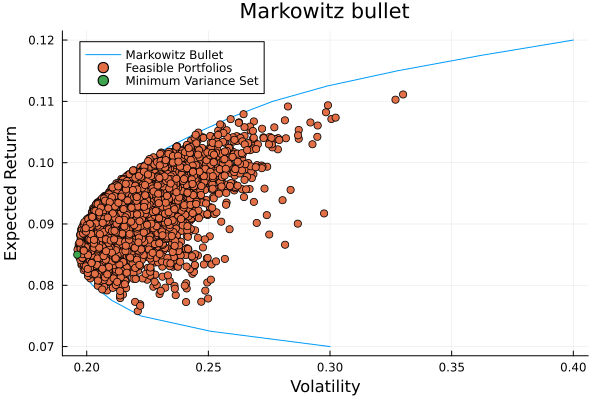

In [4]:
mv_mat=zeros(21,2)

for i=1:21
    mdl=Model(Ipopt.Optimizer)
    set_silent(mdl)
    @variable(mdl,0<=w[1:5])
    @constraint(mdl, sum(w)==1)
    @constraint(mdl,sum(w.*Rets)==0.07 + 0.0025*(i-1))
    @objective(mdl,Min,w'*Q*w)
    optimize!(mdl)
    wopt=value.(w)
    mv_mat[i,:]=[wopt'*Rets sqrt(wopt'*Q*wopt)]
end
num_portfolios = 5000
all_weights = [generate_weights(5) for _ in 1:num_portfolios]
port_returns = []
port_volatilities = []
for weights in all_weights
    port_return, port_volatility = portfolio_performance(weights, Rets, Q)
    push!(port_returns, port_return)
    push!(port_volatilities, port_volatility)
end
_, idx = findmin(mv_mat[:, 2])
# scatter(sim_pf[:,2],sim_pf[:,1])
plot(mv_mat[:,2],mv_mat[:,1], title="Markowitz bullet", majorgrid=true, label = "Markowitz Bullet")
scatter!(port_volatilities, port_returns, label = "Feasible Portfolios")
scatter!([mv_mat[idx, 2]], [mv_mat[idx, 1]], label = "Minimum Variance Set")
xlabel!("Volatility")
ylabel!("Expected Return")

In [5]:
weights, tRet, tVol = find_tangency_portfolio(Rets, Q, 0.05)

([0.1594718537922806, 1.856035899730729e-7, 0.4492137219434727, 0.30135329313262493, 0.08996094552803181], 0.10193801376341888, 0.2309273777046171)

The tangency portfolio given a 5% risk-free rate is the portfolio [0.10250000000000002, 0.2334741700702441] with weights [0.1594718537922806, 1.856035899730729e-7, 0.4492137219434727, 0.30135329313262493, 0.08996094552803181

]

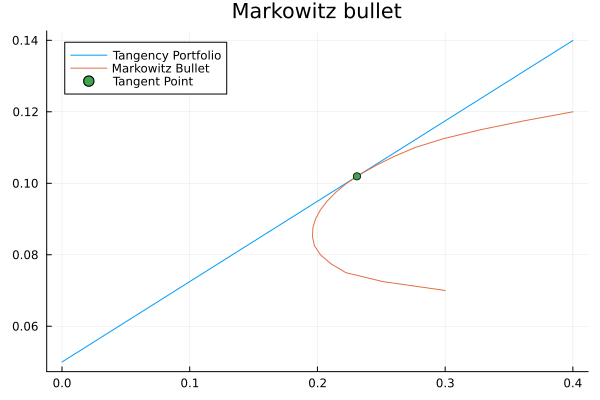

In [6]:
rf = 0.05
SharpeRatios = (mv_mat[:,1] .- rf)./mv_mat[:,2]
# print(SharpeRatios)
_, idx = findmax(SharpeRatios)
tangencyPort = mv_mat[idx, :]
print("The tangency portfolio given a 5% risk-free rate is the portfolio ", mv_mat[idx, :], " with weights ", weights)
x = range(0, 0.4, length=100)
y = (mv_mat[idx,1] - 0.05)/mv_mat[idx,2] .* x .+ 0.05
plot(x, y, label = "Tangency Portfolio")
plot!(mv_mat[:,2],mv_mat[:,1], title="Markowitz bullet", majorgrid=true, label = "Markowitz Bullet")
scatter!([tVol], [tRet], label = "Tangent Point")

# Question 2

## (1) Hedging Price

In [7]:
# Given data
S = 10.0  # Current stock price
K = 10.5  # Strike price
Su = 11.0  # Up state stock price
Sd = 9.0   # Down state stock price
r = 0.04   # Risk-free annual interest rate
T = 0.25   # Time to maturity in years

# Calculate the call option payoffs in the up and down states
Cu = max(Su - K, 0)
Cd = max(Sd - K, 0)

# 1. Hedging Method
Δ = (Cu - Cd) / (Su - Sd)
B = (Cu - Δ * Su) * exp(-r * T)
C_hedge = Δ * S + B
print("Price of a call with Hedging is ", round(X; digits = 3))

UndefVarError: UndefVarError: `X` not defined

## (2) Risk-Neutral Expectation

In [8]:
Pi = ((1 + r)^(1/4) * S - 9)/(11 - 9)

X = (Pi * 0.5 + (1- Pi) * 0)/(1 + r)^(1/4)

print("Price of a call with Risk-Neutral Expectation is ", round(X; digits = 3))

Price of a call with Risk-Neutral Expectation is 0.272

## (3) Arrow-Debreu State Pricing Methods

In [9]:
model2=Model(Ipopt.Optimizer)
set_silent(model2)
@variable(model2,pd>=0)
@variable(model2,pu>=0)
@constraint(model2,11*pu+9*pd==10)
@constraint(model2,1*pu+1*pd== 1/1.04^(1/4))
optimize!(model2)
prices2=[value(pd),value(pu)]
print("Price of a call with Arrow-Debreu State Pricing is ", round(prices2[2] * 0.5, digits = 3))

Price of a call with Arrow-Debreu State Pricing is 0.272

# Question 3

In [10]:
# Optimization model
model = Model(Ipopt.Optimizer)
set_silent(model)
@variable(model, weights[1:5] >= 0)
@constraint(model, sum(weights) == 1)  # Weights sum to 1

# Objective: Maximize using definition given in Q3
portfolio_return = sum(weights[i] * Rets[i] for i in 1:5)
portfolio_variance = sum(weights[i] * weights[j] * Q[i,j] for i in 1:5, j in 1:5)
@objective(model, Max, portfolio_return - 0.5 * portfolio_variance)

optimize!(model)

optimized_weights = value.(weights)
optimized_return = value(portfolio_return)
optimized_variance = value(portfolio_variance)
optimized_std_dev = sqrt(optimized_variance)

sharpe_ratio_Q1 = (optimized_return - rf) / optimized_std_dev

print("Sharpe Ratio from Log-Utility function was ", round(sharpe_ratio_Q1, digits = 6), ", compared with an Original Sharpe Ratio of ", round(SharpeRatios[idx], digits = 6), " in our original calculation.")

Sharpe Ratio from Log-Utility function was 0.2248974458177087, compared with an Original Sharpe Ratio of 0.22486427506822118 in our original calculation.

The values here are very similar, although we see that our Log-Utility Function finds a slight improvement on the original maximum we found earlier. This is likely due to the objective function, which now penalises high variance while rewarding a higher portfolio return.

# Question 4

In [11]:
model2=Model(Ipopt.Optimizer)
set_silent(model2)
@variable(model2,pd>=0)
@variable(model2, pn >= 0)
@variable(model2,pu >=0)
@constraint(model2,11.7*pu + 10 * pn +8.3*pd==10)
@constraint(model2,(pu + pn + pd)== 1/1.04^(1/4))
@constraint(model2,1.2 * pu == 0.24)
optimize!(model2)
prices2=[value(pu), value(pn), value(pd)]
print("Price of a 9.50 call with Arrow-Debreu State Pricing is ", round(prices2[1] * 2.2 + 0.5 * prices2[2], digits = 3))

Price of a 9.50 call with Arrow-Debreu State Pricing is 0.764